In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from math import pi,log
import matplotlib as mpl

# import basic plot tools
from qiskit.visualization import plot_histogram

# map to Statevector
from qiskit.quantum_info import Statevector




# Incrementers and Decrementers

Incrementers and decrementers are needed in order to calculate the neighbouring vertices of a given vertex.

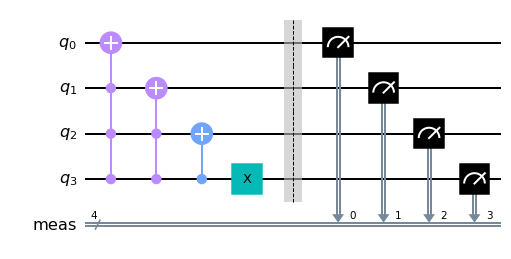

In [2]:
def increment(n_adder):
    
    qc = QuantumCircuit(n_adder)
    
    for i in range(n_adder-2):
        qc.mcx(list(range(i+1, n_adder)),i)
    
    qc.cx(n_adder-1, n_adder-2)
    qc.x(n_adder-1)
    
    U_inc = qc.to_gate()
    U_inc.name = "U$_{inc}$"
    
    return U_inc


def decrement(n_sub):
    
    qc = QuantumCircuit(n_sub)
    
    qc.x(n_sub-1)
    qc.cx(n_sub-1, n_sub-2)
    
    for i in range(n_sub-3, -1, -1):
        qc.mcx(list(range(i+1, n_sub)),i)
               
    U_dec = qc.to_gate()
    U_dec.name = "U$_{dec}$"
    
    return U_dec

qc = QuantumCircuit(4)

qc.append(increment(4), [0,1,2,3])
qc.measure_all()

qc.decompose().draw('mpl')

# Shift Operation $S$

$S$ takes the walker's position and a direction and outputs the new position after taking one step in the given direction. 

For example, $S(\lvert000\rangle_{pos} \otimes\lvert000\rangle_{dir}) = \lvert001\rangle_{pos}\otimes\lvert000\rangle_{dir}$.

Since there are only six possible directions in a cube, $\lvert110\rangle_{dir}$ and $\lvert111\rangle_{dir}$ result in no change in position (an arbitrary choice).


In [3]:
def shift(n_dir, n_pos):
    
    LEN_ONE_SIDE_OF_CUBE = 4
    HALF_LEN = math.ceil(LEN_ONE_SIDE_OF_CUBE / 2)
    
    qr = QuantumRegister(n_dir+n_pos)
    q_dir = qr[:n_dir]
    q_pos = qr[n_dir:]
    
    qc = QuantumCircuit(qr)
    
    # if direction is 000 (RIGHT)
    qc.x(q_dir)
    qc.append(increment(HALF_LEN).control(3), q_dir+q_pos[-HALF_LEN:])
    qc.x(q_dir)
    
    # if direction is 001 (DOWN)
    qc.x(q_dir[0])
    qc.x(q_dir[1])
    qc.append(increment(HALF_LEN).control(3), q_dir+q_pos[HALF_LEN:-HALF_LEN])
    qc.x(q_dir[0])
    qc.x(q_dir[1])
    
    # if direction is 010 (LEFT)
    qc.x(q_dir[0])
    qc.x(q_dir[2])
    qc.append(decrement(HALF_LEN).control(3), q_dir+q_pos[-HALF_LEN:])
    qc.x(q_dir[0])
    qc.x(q_dir[2])
    
    # if direction is 011 (UP)
    qc.x(q_dir[0])
    qc.append(decrement(HALF_LEN).control(3), q_dir+q_pos[HALF_LEN:-HALF_LEN])
    qc.x(q_dir[0])
    
    # if direction is 100 (BACK)
    qc.x(q_dir[1])
    qc.x(q_dir[2])
    qc.append(increment(HALF_LEN).control(3), q_dir+q_pos[:HALF_LEN])
    qc.x(q_dir[1])
    qc.x(q_dir[2])
    
    # if direction is 101 (FORWARD)
    qc.x(q_dir[1])
    qc.append(decrement(HALF_LEN).control(3), q_dir+q_pos[:HALF_LEN])
    qc.x(q_dir[1])
    
    # if direction is 110
    
    # if direction is 111
    
    
    U_shift = qc.to_gate()
    U_shift.name = "U$_{shift}$"
    return U_shift


# The full Quantum Walk algorithm

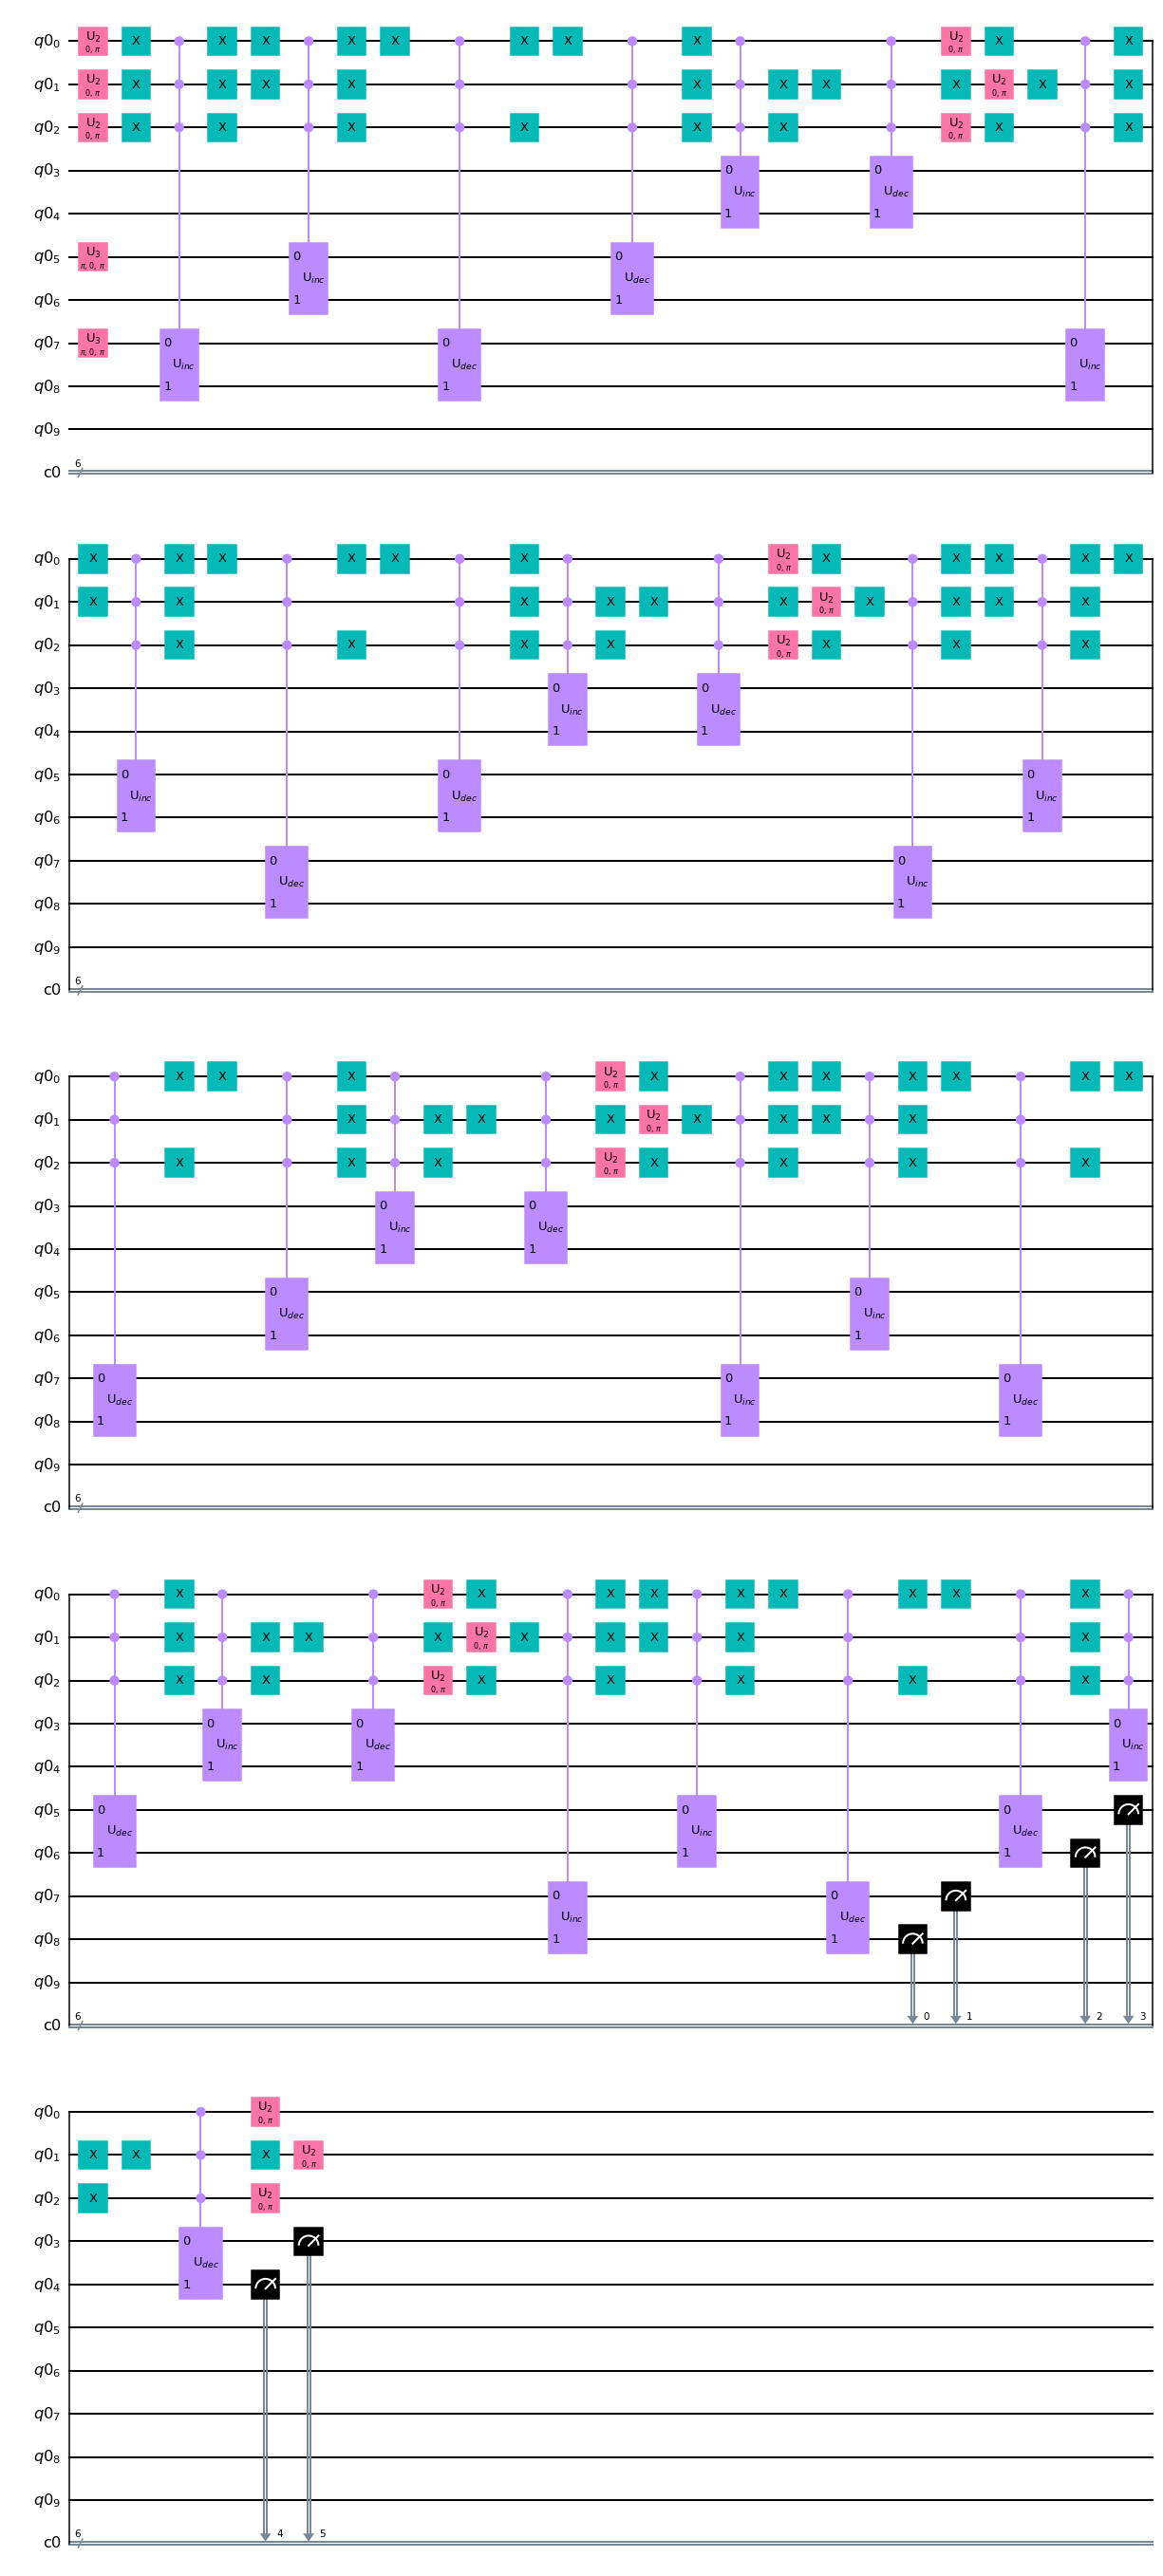

In [4]:
n_dir = 3 # number of qubits required to represent all directions
n_pos = 6 # number of qubits required to represent all positions
iterations = 5

qwalk_reg = QuantumRegister(n_dir+n_pos+1)

# allocating qubits
q_dir = qwalk_reg[:n_dir]
q_pos = qwalk_reg[n_dir:n_dir+n_pos]
q_anc = qwalk_reg[n_dir+n_pos]

# lists of indices
dir_ind = list(range(n_dir))
pos_ind = list(range(n_dir+n_pos))[n_dir:]
anc_ind = n_dir+n_pos

qwalk_circ = QuantumCircuit(qwalk_reg, ClassicalRegister(n_pos))

# set up the initial position:

# start in position 001010
qwalk_circ.x(q_pos[2]) 
qwalk_circ.x(q_pos[4])
    
# set up the initial direction(s)
for qubit in q_dir:
    qwalk_circ.h(qubit)
    

## begin state harvesting
states = []
states.append(Statevector.from_instruction(qwalk_circ))


for i in range(iterations):
    
    ### Toggle for use of Target State:
    
    #qwalk_circ.mcx(pos_ind, anc_ind) # oracle, target is |11111..1>
    
    # controlled shift where ancilla is control
    # only shift if we are in a non-target state
    #qwalk_circ.x(q_anc)
    
    ###
    
    qwalk_circ.append(shift(n_dir, n_pos), dir_ind+pos_ind)
    
    
    ### Toggle for use of Target State
    
    #qwalk_circ.x(q_anc)
    #qwalk_circ.reset(q_anc)
    
    ###                                
    
    
    ### Toggle to reset directions to be equal positive superposition (no destructive interference)
    
    #qwalk_circ.reset(q_dir)
    
    ###   
    
    qwalk_circ.h(q_dir)
    
    # harvest state
    states.append(Statevector.from_instruction(qwalk_circ))
    
    
qwalk_circ.measure(pos_ind, list(range(n_pos))[::-1]) # reversed to print in Big Endian form

qwalk_circ.decompose().draw('mpl')

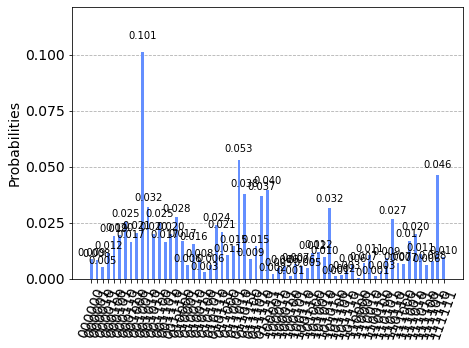

In [5]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_circuit = transpile(qwalk_circ, aer_sim)
qobj = assemble(transpiled_circuit)
results = aer_sim.run(qobj, shots=2048).result()
counts = results.get_counts()
plot_histogram(counts)

# 2D Model Construction and Rendering
In this scenario, the model is cut into layers and each layer is rendered separately.


16


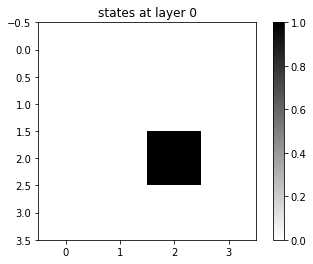

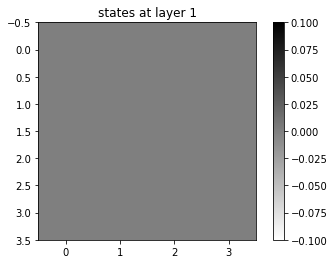

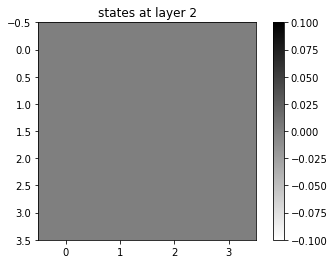

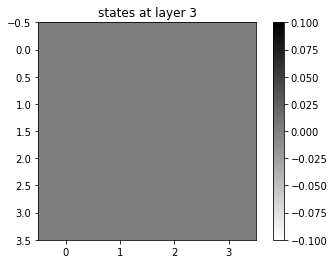

16


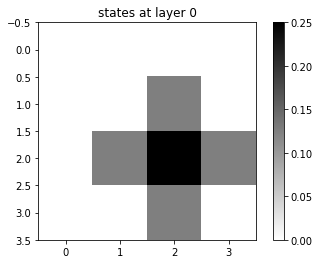

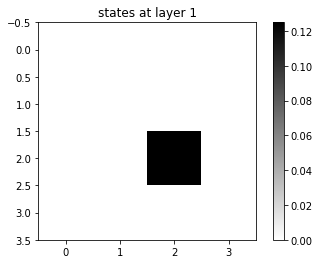

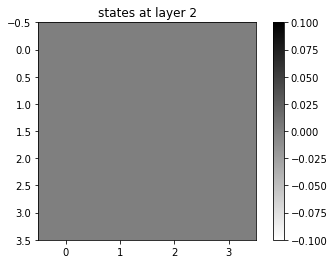

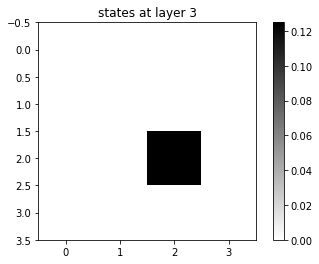

16


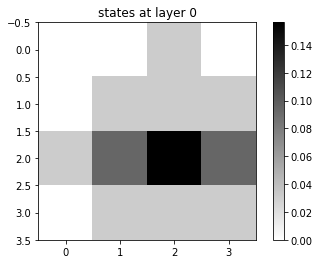

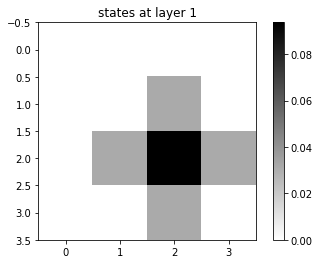

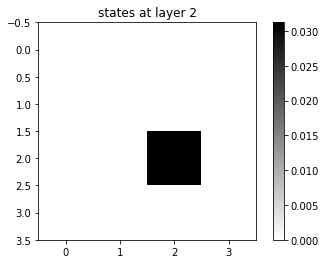

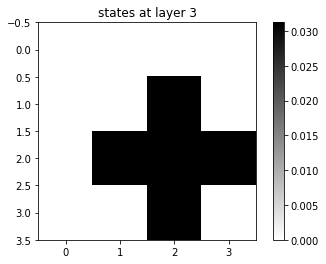

16


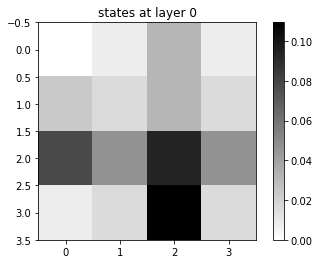

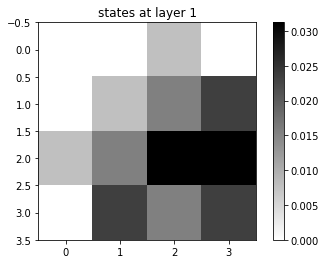

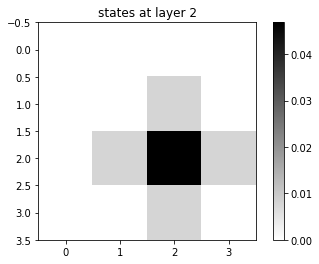

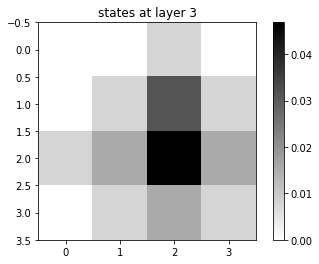

16


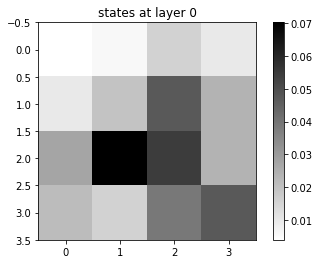

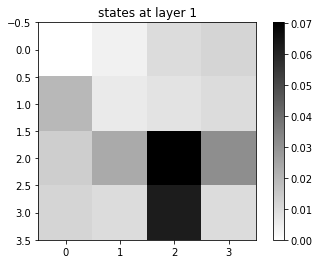

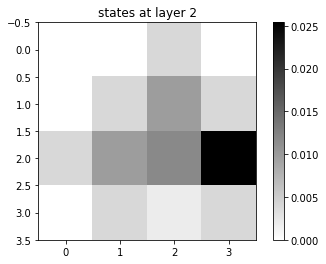

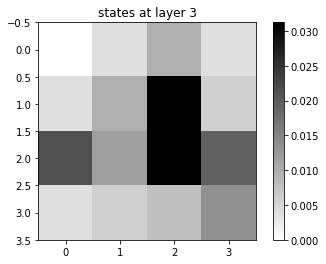

16


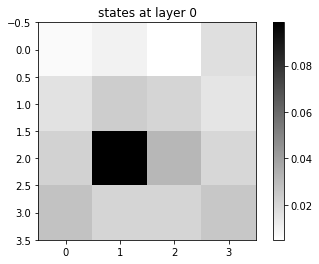

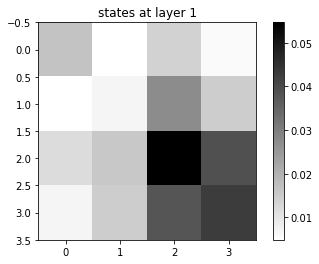

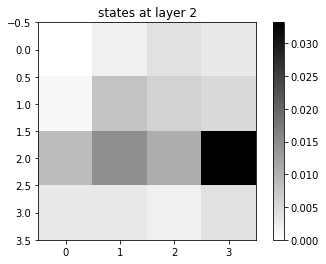

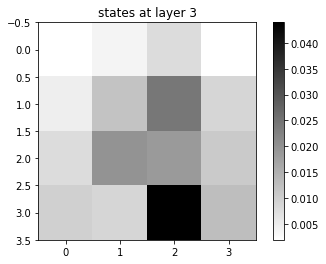

In [8]:
def round_remove_zeroes(np_dict):
    for a,d in np.ndenumerate(np_dict):
        for k,v in d.items():
            d[k] = round(v, 5)
    
    new_dict = {}
    for a,d in np.ndenumerate(np_dict):
        for k,v in d.items():
            if v:
                new_dict[k] = v
                
    return new_dict

def layers(data):
    n = int(np.cbrt(len(data))**2) # take square of the cubic root to get size of 2D layer
    print(n)
    return np.array([[data[i:i+n]] for i in range(0, len(data), n)]) # array of layer slices
    
def process_statevector(state):
    np_dict_all = round_remove_zeroes(np.array(state.probabilities_dict([8,7,6,5,4,3,2,1,0])))
    #print("All qubits:", np_dict_all)
    
    np_dict = round_remove_zeroes(np.array(state.probabilities_dict([8,7,6,5,4,3])))         
#     print("Position qubits:",np_dict)
    
    data = np.around(np.array(state.probabilities([8,7,6,5,4,3])), 5)
    data = layers(data)
    data = np.array([np.reshape(data[i], (4,4)) for i in range(len(data))])
    
    return data

for state in states:

    data = process_statevector(state)
    
    for i in range(len(data)):
        # plot each layer
        plt.title("states at layer {}".format(i))
        pixel_plot = plt.imshow(
          data[i], cmap='binary')
        plt.colorbar(pixel_plot)
        
#         print("Data:",data)
        plt.show(pixel_plot)

# 3D model construction and rendering

In [23]:
# input to layers

def layers(data):
    n = int(np.cbrt(len(data))**2) # take square of the cubic root to get size of 2D layer
    return np.array([[data[i:i+n]] for i in range(0, len(data), n)]) # array of layer slices


def to_3d(data):
    length = int(len(data)**(1/3))
    area = int(len(data)**(2/3))
    
    new = np.zeros([length for i in range(3)])
    
    return new


for state in states:
    np_dict_all = round_remove_zeroes(np.array(state.probabilities_dict([8,7,6,5,4,3,2,1,0])))
    
    np_dict = round_remove_zeroes(np.array(state.probabilities_dict([8,7,6,5,4,3])))         
    
    data = np.around(np.array(state.probabilities([8,7,6,5,4,3])), 5)
    print(to_3d(data))



[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


In [24]:
import model
import importlib
importlib.reload(model)
Model = model.Model

In [25]:
model = Model(states[1])

16


In [26]:
print(model.data)

[0.    0.    0.    0.    0.    0.    0.125 0.    0.    0.125 0.25  0.125
 0.    0.    0.125 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.125 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.125 0.
 0.    0.    0.    0.   ]


In [ ]:
model.display_model()